In [1]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import tempfile
import os
import logging
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

try:
    CLIENT = storage.Client()
except:
    CLIENT = storage.Client.from_service_account_json('../royaleapp-296a6cea39ad.json')
BUCKET = CLIENT.bucket('royale-data')

In [2]:
def get_latest_file(fname, folder_name='live_app_data'):
    blobs = BUCKET.list_blobs(prefix=folder_name)
    fname_blobs = [b.name.split('/')[1] for b in blobs if fname in b.name]
    latest_fname = sorted(fname_blobs)[-1]
    latest_fname_blob = BUCKET.get_blob(folder_name+'/'+latest_fname)
    if latest_fname.endswith('.json'):
        data = json.loads(latest_fname_blob.download_as_string())
    elif latest_fname.endswith('.xlsx'):
        data = pd.read_excel(BytesIO(latest_fname_blob.download_as_string()))
    elif latest_fname.endswith('.ann'):
        temp_file = tempfile.NamedTemporaryFile(mode='w', delete=False)
        latest_fname_blob.download_to_filename(temp_file.name)
        data = AnnoyIndex(714, 'dot')
        data.load(temp_file.name)
        temp_file.close()
        try:
            os.remove(temp_file.name)
        except:
            pass
    logging.info(f"{latest_fname} loaded.")
    return data

def scree_plot(X, pca_object):
    # Find the right number of components with a scree plot
    variance = PCA(random_state=42).fit(X).explained_variance_
    cumulative_variance = np.cumsum(variance)/sum(variance)*100
    x_vals = np.arange(1, X.shape[1]+1)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx() 

    ax1.set_xlabel('Principal Component')
    ax1.set_xticks(x_vals)

    ax1.set_ylabel('Explained Variance', color='r')
    ax1.plot(x_vals, variance, 'r-o')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2.plot(x_vals, cumulative_variance, 'b-o')
    ax2.set_ylabel('Cumulative Explained Variance', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    plt.show();

In [3]:
df_stats = get_latest_file('card_stats.xlsx')
names = df_stats['name'].values
vals = df_stats.values[:,1:]

names.shape, vals.shape

((99,), (99, 34))

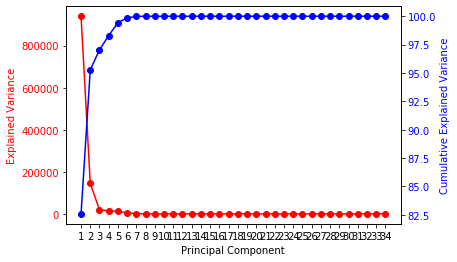

In [4]:
scree_plot(vals, PCA(random_state=42).fit(vals))

In [5]:
len(plt.cm.Set1.colors), len(plt.cm.Dark2.colors)

(9, 8)

In [20]:
def get_traces(data, target, eig_vectors, loadings, dot_opacity):
    traces = []
    # plot each class on the first 3 principal components
    for feat in range(len(np.unique(target))):
        pc_trace = go.Scatter3d(
            x = data[:,0][np.where(target==feat)],
            y = data[:,1][np.where(target==feat)],
            z = data[:,2][np.where(target==feat)],
            mode='markers',
            marker=dict(
                color='rgba(44, 130, 201, 1)',
                size=12,
                line=dict(
                    color='black',
                    width=0.5,
                ),
                opacity=dot_opacity
            ),
            name='Class {}'.format(feat+1)        
        )
        traces.append(pc_trace)
        
    # plot the eigenvector for each feature
    for eig_feat in range(eig_vectors.shape[0]):
        eig_trace = go.Scatter3d(
            x=[0, eig_vectors[eig_feat][0]], 
            y=[0, eig_vectors[eig_feat][1]], 
            z=[0, eig_vectors[eig_feat][2]],
            marker=dict(
                size=5,
                color='rgba(44, 130, 201, 1)'
            ),
            line=dict(
                color='rgba(44, 130, 201, 1)',
                width=3
            ),
            name=target[eig_feat]
        )
        traces.append(eig_trace)
        
#     # plot the loading for each feature
#     for loading in range(loadings.shape[0]):
#         load_trace = go.Scatter3d(
#             x=[0, loadings[loading][0]], 
#             y=[0, loadings[loading][1]], 
#             z=[0, loadings[loading][2]],
#             marker=dict(
#                 size=5,
#                 color='rgba(44, 130, 201, 1)'
#             ),
#             line=dict(
#                 color='rgba(44, 130, 201, 1)',
#                 width=3
#             ),
#             name=target[loading]
#         )
#         traces.append(load_trace)
        
    return traces

def plot_3d(data, target, eig_vectors, loadings, dot_opac=0.3):
    data = get_traces(data, target, eig_vectors, loadings, dot_opac)
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        scene = {
            'xaxis':{'title':'PC 1'},
            'yaxis':{'title':'PC 2'},
            'zaxis':{'title':'PC 3'}
        }
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [21]:
# Perform PCA with 3 components
n_components = 3
pca = PCA(random_state=42).fit(vals.T)
X_transformed = pca.transform(vals.T)
eigenvectors = pca.components_.T
loadings = eigenvectors * np.sqrt(pca.explained_variance_)

# Plot the first three principal components
plot_3d(X_transformed, names, eigenvectors, loadings)

In [8]:
# https://plotly.com/python/pca-visualization/
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(vals)

fig = px.scatter(components, x=0, y=1, color=names)
fig.show()

In [9]:
pca = PCA(n_components=3)
components = pca.fit_transform(vals)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df_stats['name'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [13]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

df = df_stats
features = df_stats.columns[1:]
X = df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['name'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [23]:
loadings.shape

(99, 34)